In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import tensorflow 
import tensorflow.keras as keras
from keras import Model,layers
from keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import train_test_split

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/convlstm-cyclone-formation/keras/default/1/best_convlstm (1).keras
/kaggle/input/convlstm-cyclone-formation/keras/default/1/norm_stats_1 (1).npz
/kaggle/input/ibtracs/ibtracs.NI.list.v04r01.csv
/kaggle/input/cyclone-features-and-labels/Features_data.npy
/kaggle/input/cyclone-features-and-labels/Label_data.npy


2025-10-03 06:27:38.929359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759472859.141061      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759472859.199269      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preprocessing 
**Initally merging the previous cyclone positive labels with speed, position cordinates to pass as input in model**

In [3]:
!gdown 105W7hPrEaHv_SmeDpMYQMbwws8CEUMJR #Features2 1990-2000
!gdown 1rg3FPQ6HidSX-ZjtKKGKZEaIJC_pcFxH #Feature3 2000-2008
!gdown 18aPfj95axsxx_8_iAqI9VIwgqO9e888B #Label2 
!gdown 1XInPa3BynTR3AjgEn6CgU_9egzXnXk5s

Downloading...
From (original): https://drive.google.com/uc?id=105W7hPrEaHv_SmeDpMYQMbwws8CEUMJR
From (redirected): https://drive.google.com/uc?id=105W7hPrEaHv_SmeDpMYQMbwws8CEUMJR&confirm=t&uuid=61037594-733f-47fd-b0e6-675d09ddf849
To: /kaggle/working/Features2_data.npy
100%|███████████████████████████████████████| 3.63G/3.63G [00:19<00:00, 182MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1rg3FPQ6HidSX-ZjtKKGKZEaIJC_pcFxH
From (redirected): https://drive.google.com/uc?id=1rg3FPQ6HidSX-ZjtKKGKZEaIJC_pcFxH&confirm=t&uuid=502348ca-deea-4d15-bfba-beaa4e17a206
To: /kaggle/working/Features3_data.npy
100%|███████████████████████████████████████| 2.64G/2.64G [00:17<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=18aPfj95axsxx_8_iAqI9VIwgqO9e888B
To: /kaggle/working/Label2_data.npy
100%|██████████████████████████████████████| 32.3k/32.3k [00:00<00:00, 48.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XInPa3BynTR3AjgEn6CgU_9egzXnXk5s
To: /

In [4]:
# PATHS FOR EVERY - DATASET 
X1_path = "/kaggle/input/cyclone-features-and-labels/Features_data.npy"
X2_path = "/kaggle/working/Features2_data.npy"
X3_path = "/kaggle/working/Features3_data.npy"

Y1_path = "/kaggle/input/cyclone-features-and-labels/Label_data.npy"
Y2_path = "/kaggle/working/Label2_data.npy"
Y3_path = "/kaggle/working/Label3_data.npy"

In [5]:
X = np.load(X1_path)
X2 = np.load(X2_path)
X3 = np.load(X3_path)
print(f"shape of Features : {X.shape} year : 2010-2024")
print(f"shape of Features : {X2.shape} year : 2001-2008")
print(f"shape of Features : {X3.shape} year : 1990-2000")

shape of Features : (5479, 6, 224, 168) year : 2010-2024
shape of Features : (4018, 6, 224, 168) year : 2001-2008
shape of Features : (2922, 6, 224, 168) year : 1990-2000


In [6]:
X_Full = np.concatenate([X3,X2,X],axis=0)
print(X_Full.shape)

(12419, 6, 224, 168)


In [7]:
Y = np.load("/kaggle/input/cyclone-features-and-labels/Label_data.npy")
Y2 = np.load(Y2_path)
Y3 = np.load(Y3_path)

Y_Full = np.concatenate([Y3,Y2,Y])
print(Y_Full.shape)

(12419,)


In [8]:
Cyclone_df = pd.read_csv("/kaggle/input/ibtracs/ibtracs.NI.list.v04r01.csv", low_memory=False)
df = Cyclone_df[(Cyclone_df["LAT"].notna()) & (Cyclone_df["LON"].notna())]
df = df[1:]
df[["LAT","LON"]]=df[["LAT","LON"]].astype(np.float32)


# Bay of Bengal bounding box
bengal_mask = df[(df["LAT"] >= 5) & (df["LAT"] <= 25) &
            (df["LON"] >= 80) & (df["LON"] <= 100)]

bengal_mask[["SEASON","ISO_TIME", "LAT", "LON", "WMO_WIND", "WMO_PRES", 'WMO_WIND', 'USA_WIND','BASIN', 'SUBBASIN']]

bengal_mask["CYCLONE_FLAG"] = 1

# Convert ISO_TIME column to datetime
bengal_mask["ISO_TIME"] = pd.to_datetime(bengal_mask["ISO_TIME"], errors="coerce")

# Now extract only the date part
bengal_mask["DATE"] = bengal_mask["ISO_TIME"].dt.date

# Group by DATE and get max CYCLONE_FLAG (1 if cyclone present that day)
daily_labels = bengal_mask.groupby("DATE")["CYCLONE_FLAG"].max().reset_index()

print(daily_labels.head())

         DATE  CYCLONE_FLAG
0  1842-10-25             1
1  1877-05-15             1
2  1877-05-16             1
3  1877-05-17             1
4  1877-05-18             1


/tmp/ipykernel_36/3697076803.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bengal_mask["CYCLONE_FLAG"] = 1
/tmp/ipykernel_36/3697076803.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bengal_mask["ISO_TIME"] = pd.to_datetime(bengal_mask["ISO_TIME"], errors="coerce")
/tmp/ipykernel_36/3697076803.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

**Creating a dataframe for speed log lat values for further prediction**

In [9]:
# Load dataset
df = pd.read_csv("/kaggle/input/ibtracs/ibtracs.NI.list.v04r01.csv", low_memory=False)
cols = ['SEASON', 'BASIN', 'SUBBASIN', 'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'USA_WIND']
df = df[cols].copy()
df['SEASON'] = pd.to_numeric(df['SEASON'], errors='coerce')
df = df.dropna(subset=['SEASON'])
df['SEASON'] = df['SEASON'].astype(int)
df = df[(df['SEASON'] >= 1990) & (df['SEASON'] <= 2024) & (df['SEASON'] != 2009)]
print("Unique Years only ...")
print(df['SEASON'].unique())
if "SUBBASIN" in df.columns:
    df = df[df['SUBBASIN'] == 'BB']
else:
    df = df[df['BASIN'] == 'NI']  
df['speed'] = df['WMO_WIND'].fillna(df['USA_WIND'])
df = df.dropna(subset=['speed'])
df["LAT"] = pd.to_numeric(df["LAT"],errors="coerce")
df["LON"] = pd.to_numeric(df["LON"],errors="coerce")
df["speed"] = pd.to_numeric(df["speed"],errors="coerce")
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'], errors='coerce')
df = df.dropna(subset=['ISO_TIME'])
df['date'] = df['ISO_TIME'].dt.date

daily_df = df.groupby('date').agg({
    'LAT': 'mean',        # average latitude for the day
    'LON': 'mean',        # average longitude for the day
    'speed': 'max'        # maximum speed for the day
}).reset_index()

daily_df["date"] = pd.to_datetime(daily_df["date"])

# Interpolate speed per year (stays numeric)
daily_df["speed"] = (
    daily_df.groupby(daily_df["date"].dt.year)["speed"]
    .transform(lambda x: x.interpolate(method="linear").fillna(x.median()))
)

# Backup fill for any leftover NaN
daily_df["speed"] = daily_df["speed"].fillna(daily_df["speed"].median())

# Rename columns
daily_df = daily_df.rename(columns={'LAT': 'lat', 'LON': 'lon'})

print(daily_df.head(10))
print(daily_df.shape)


Unique Years only ...
[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022 2023 2024]
        date      lat      lon  speed
0 1990-04-17  10.1750  86.7250   27.0
1 1990-04-18  13.6400  87.5000   27.0
2 1990-05-03   9.1750  87.8250   27.0
3 1990-05-04   9.1500  86.6125   25.0
4 1990-05-05  10.0125  84.6250   55.0
5 1990-05-06  10.3250  83.0000   77.0
6 1990-05-07  11.5875  81.9625  115.0
7 1990-05-08  13.9125  81.3125  127.0
8 1990-05-09  15.6375  80.8500   90.0
9 1990-05-10  17.9250  79.7875   65.0
(1133, 4)


In [10]:
daily_labels["DATE"] = pd.to_datetime(daily_labels["DATE"]).dt.date
aligned_df = daily_df[daily_df["date"].isin(daily_labels["DATE"])].copy()
aligned_df.reset_index(drop=True, inplace=True)
print("Aligned shape:", aligned_df.shape)  
print(aligned_df.tail())

Aligned shape: (1059, 4)
           date        lat        lon  speed
1054 2024-10-24  19.600000  87.537500   30.0
1055 2024-10-25  21.157143  86.514286   30.0
1056 2024-11-29  12.450000  81.750000   30.0
1057 2024-11-30  12.350000  80.700000   30.0
1058 2024-12-01  12.100000  79.600000   30.0


/tmp/ipykernel_36/1522146398.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  aligned_df = daily_df[daily_df["date"].isin(daily_labels["DATE"])].copy()


**Aligning Images as per labels**

In [11]:
pos_idx = np.where(Y_Full==1)[0]
print("Positive Samples:",len(pos_idx))
X_features = X_Full[pos_idx]
print("Positive Cyclone days Images:",X_features.shape)

Positive Samples: 1059
Positive Cyclone days Images: (1059, 6, 224, 168)


**Label creation**

In [12]:
y_lat = aligned_df["lat"].values.astype(np.float32)
y_lon = aligned_df["lon"].values.astype(np.float32)
y_speed = aligned_df["speed"].values.astype(np.float32)

# Model creation
**Fine-tuning previously used Convlstm model to predict speed and position coordinates**

In [13]:
from tensorflow.keras.models import load_model
Convlstm = load_model("/kaggle/input/convlstm-cyclone-formation/keras/default/1/best_convlstm (1).keras")
print("model summary before fine-tunning")
Convlstm.summary()

I0000 00:00:1759472962.444228      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759472962.444899      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


model summary before fine-tunning


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 224, 168,    │        45,056 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 224, 168,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 224, 168, 32)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 168, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370,309 (1.41 MB)

 Trainable params: 123,393 (482.00 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 246,788 (964.02 KB)

In [14]:
from tensorflow.keras import layers, Model
TIME_STEPS = 5
HEIGHT = 224
WIDTH  = 168
BANDS  = 6               # physical bands (before mask)
CHANNELS = 7 
inp = layers.Input(shape=(TIME_STEPS, HEIGHT, WIDTH, CHANNELS))

x = inp
for layer in Convlstm.layers[:-1]:  
    x = layer(x)

for layer in Convlstm.layers[:-1]:
    layer.trainable = False

x = layers.Dense(128, activation="relu", name="stage2_dense")(x)
x = layers.Dropout(0.3, name="stage2_dropout")(x)

Input_lat = layers.Dense(128, name="Input_lat")(x)
Input_lon = layers.Dense(128, name="Input_lon")(x)
Input_speed = layers.Dense(128, name="Input_speed")(x)

out_lat = layers.Dense(1, name="out_lat")(Input_lat)
out_lon = layers.Dense(1, name="out_lon")(Input_lon)
out_speed = layers.Dense(1, name="out_speed")(Input_speed)

# Build Stage-2 model
stage2_model = Model(inputs=inp, outputs=[out_lat, out_lon, out_speed])
stage2_model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 224,    │          0 │ -                 │
│ (InputLayer)        │ 168, 7)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 5, 224,    │     45,056 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 168, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5, 224,    │        128 │ conv_lstm2d[8][0] │
│ (BatchNormalizatio… │ 168, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 224, 168,  │     73,856 │ batch_normalizat… │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 168,  │        128 │ conv_lstm2d_1[6]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      4,224 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[3][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_dense        │ (None, 128)       │     16,512 │ dropout[2][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_dropout      │ (None, 128)       │          0 │ stage2_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_lat (Dense)   │ (None, 128)       │     16,512 │ stage2_dropout[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_lon (Dense)   │ (None, 128)       │     16,512 │ stage2_dropout[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_speed (Dense) │ (None, 128)       │     16,512 │ stage2_dropout[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_lat (Dense)     │ (None, 1)         │        129 │ Input_lat[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_lon (Dense)     │ (None, 1)         │        129 │ Input_lon[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_speed (Dense)   │ (None, 1)         │        129 │ Input_speed[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 189,827 (741.51 KB)

 Trainable params: 66,435 (259.51 KB)

 Non-trainable params: 123,392 (482.00 KB)

In [15]:
import numpy as np
from tensorflow.keras.utils import Sequence

class SeqDataGenerator(Sequence):
    """
    ConvLSTM sequence generator for Stage-2 regression (lat, lon, speed)
    - NaN -> 0
    - z-score normalization per band (using saved stats)
    - mask channel appended
    - output: X: (B,T,H,W,C), Y: list of [lat, lon, speed]
    """
    def __init__(self, X, y_lat, y_lon, y_speed, seq_starts, time_steps, band_means, band_stds,
                 batch_size=8, shuffle=True, drop_remainder=True):
        self.X = X
        self.y_lat = y_lat
        self.y_lon = y_lon
        self.y_speed = y_speed
        self.seq_starts = np.array(seq_starts, dtype=np.int64)
        self.time_steps = time_steps
        self.band_means = band_means.astype(np.float32)
        self.band_stds  = band_stds.astype(np.float32)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_remainder = drop_remainder
        self.indexes = np.arange(len(self.seq_starts))
        self.on_epoch_end()

    def __len__(self):
        if self.drop_remainder:
            return len(self.indexes) // self.batch_size
        return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        if self.drop_remainder and len(batch_ids) < self.batch_size:
            batch_ids = self.indexes[-self.batch_size:]

        X_batch, Y_lat, Y_lon, Y_speed = [], [], [], []

        for bi in batch_ids:
            s = self.seq_starts[bi]
            seq_x = self.X[s:s+self.time_steps].astype(np.float32)

            # mask from first band
            m = ~np.isnan(seq_x[:, 0, :, :])           # (T,H,W)
            m = m.astype(np.float32)[:, None, :, :]    # (T,1,H,W)

            # replace NaNs
            seq_x = np.nan_to_num(seq_x, nan=0.0, posinf=0.0, neginf=0.0)

            # z-score normalization
            seq_x = (seq_x - self.band_means[None, :, None, None]) / self.band_stds[None, :, None, None]

            # append mask channel
            seq_x = np.concatenate([seq_x, m], axis=1)  # (T,7,H,W)

            # move channels last
            seq_x = np.transpose(seq_x, (0,2,3,1)).astype(np.float32)  # (T,H,W,C)

            X_batch.append(seq_x)
            Y_lat.append(self.y_lat[s + self.time_steps - 1])
            Y_lon.append(self.y_lon[s + self.time_steps - 1])
            Y_speed.append(self.y_speed[s + self.time_steps - 1])

        Xb = np.stack(X_batch, axis=0)  # (B,T,H,W,C)
        Yb =( 
            np.array(Y_lat, dtype=np.float32),
            np.array(Y_lon, dtype=np.float32),
            np.array(Y_speed, dtype=np.float32)
        )

        return Xb, Yb

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [16]:
from tensorflow.keras.callbacks import Callback

class UnfreezeCallback(Callback):
    def __init__(self, model,unfreeze_at=20, optimizer=None, 
                 losses=None, loss_weights=None, metrics=None):
        super().__init__()
        self.model_to_unfreeze = model
        self.unfreeze_at = unfreeze_at
        self.optimizer = optimizer
        self.losses = losses
        self.loss_weights = loss_weights
        self.metrics = metrics 

    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.unfreeze_at:
            print(f"\n🔓 Unfreezing last ConvLSTM block at epoch {epoch}")
            # Unfreeze last 2 ConvLSTM layers
            unfrozen = 0
            for layer in reversed(self.model_to_unfreeze.layers):
                if "ConvLSTM" in layer.__class__.__name__:
                    layer.trainable = True
                    unfrozen += 1
                    if unfrozen >= 2:
                        break
            # Re-compile to apply new trainable settings
            self.model_to_unfreeze.compile(
                optimizer=self.optimizer,
                loss=self.losses,
                loss_weights=self.loss_weights,
                metrics=self.metrics,
            )

In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler

class LogStandardScaler:
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, y):
        y_log = np.log1p(y)  # log(1 + y) to avoid log(0)
        self.scaler.fit(y_log.reshape(-1,1))
        return self
    
    def transform(self, y):
        y_log = np.log1p(y)
        return self.scaler.transform(y_log.reshape(-1,1))
    
    def inverse_transform(self, y_scaled):
        y_log = self.scaler.inverse_transform(y_scaled)
        return np.expm1(y_log)  # exp(x) - 1
    
    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

norm_stats = np.load("/kaggle/input/convlstm-cyclone-formation/keras/default/1/norm_stats_1 (1).npz")
band_means = norm_stats["band_means"]
band_stds  = norm_stats["band_stds"]

lat_scaler = MinMaxScaler(feature_range=(-1,1))
lon_scaler = MinMaxScaler(feature_range=(-1,1))
speed_scaler = LogStandardScaler()
# ==========================================================
# 1. Compute Target Normalization Stats
# ==========================================================
y_lat_norm = lat_scaler.fit_transform(y_lat.reshape(-1, 1))
y_lon_norm = lon_scaler.fit_transform(y_lon.reshape(-1, 1))
y_speed_norm = speed_scaler.fit_transform(y_speed.reshape(-1, 1))

print("y_lat_norm : ",y_lat_norm.shape)
print("y_lon_norm : ",y_lon_norm.shape)
print("y_speed_norm : ",y_speed_norm.shape)

y_lat_norm :  (1059, 1)
y_lon_norm :  (1059, 1)
y_speed_norm :  (1059, 1)


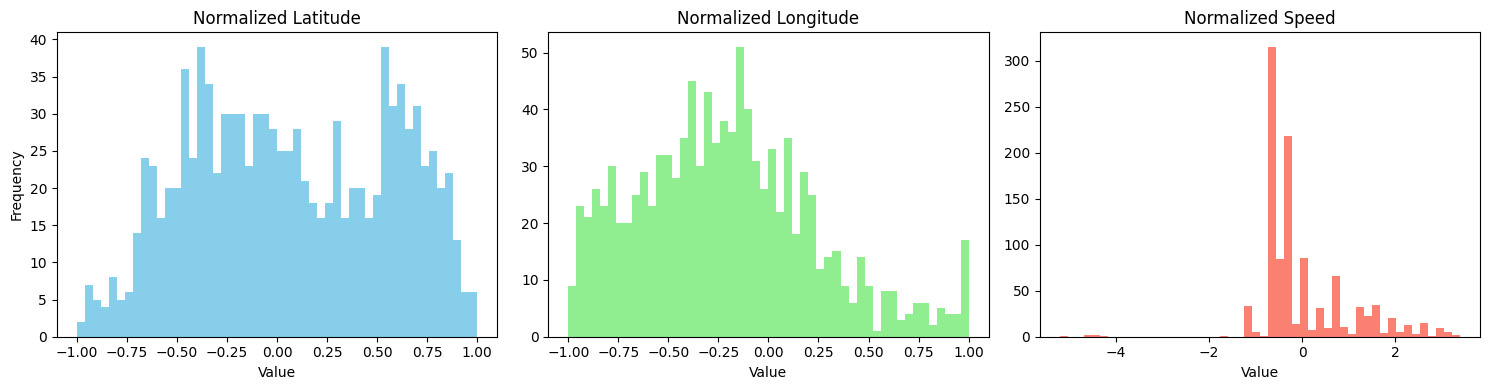

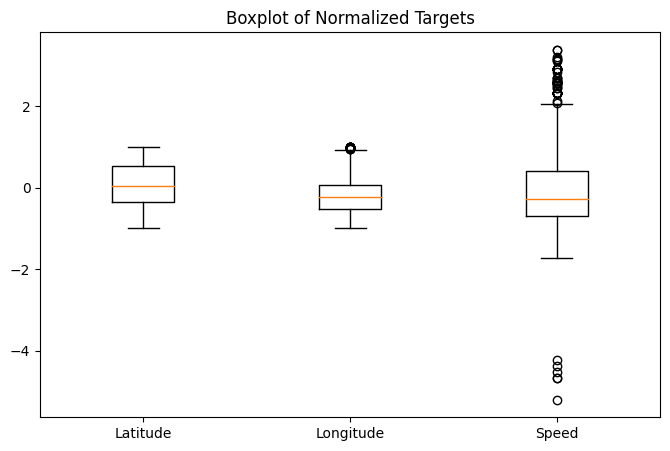

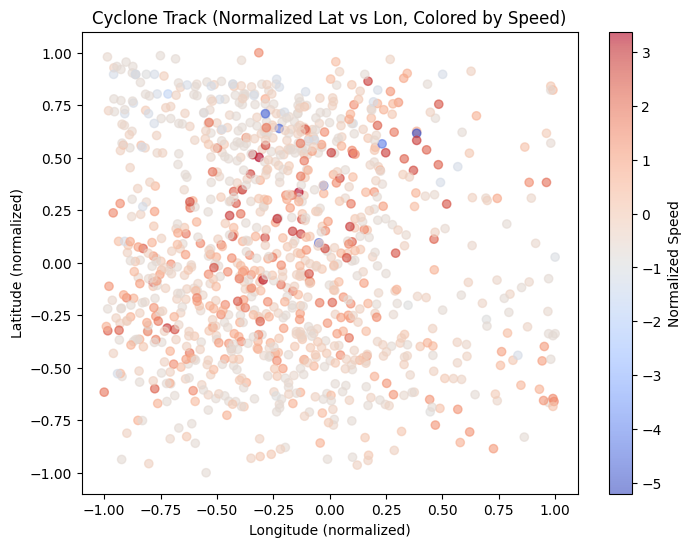

In [19]:
import matplotlib.pyplot as plt

# ==============================
# Histograms for normalized values
# ==============================
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(y_lat_norm, bins=50, color='skyblue')
plt.title("Normalized Latitude")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(y_lon_norm, bins=50, color='lightgreen')
plt.title("Normalized Longitude")
plt.xlabel("Value")

plt.subplot(1, 3, 3)
plt.hist(y_speed_norm, bins=50, color='salmon')
plt.title("Normalized Speed")
plt.xlabel("Value")

plt.tight_layout()
plt.show()

# ==============================
# Boxplots for spread/outliers
# ==============================
plt.figure(figsize=(8, 5))
plt.boxplot([y_lat_norm.flatten(), y_lon_norm.flatten(), y_speed_norm.flatten()],
            labels=['Latitude', 'Longitude', 'Speed'])
plt.title("Boxplot of Normalized Targets")
plt.show()

# ==============================
# Scatter Plot (Lat vs Lon, colored by Speed)
# ==============================
plt.figure(figsize=(8, 6))
sc = plt.scatter(y_lon_norm, y_lat_norm, c=y_speed_norm, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Normalized Speed")
plt.xlabel("Longitude (normalized)")
plt.ylabel("Latitude (normalized)")
plt.title("Cyclone Track (Normalized Lat vs Lon, Colored by Speed)")
plt.show()


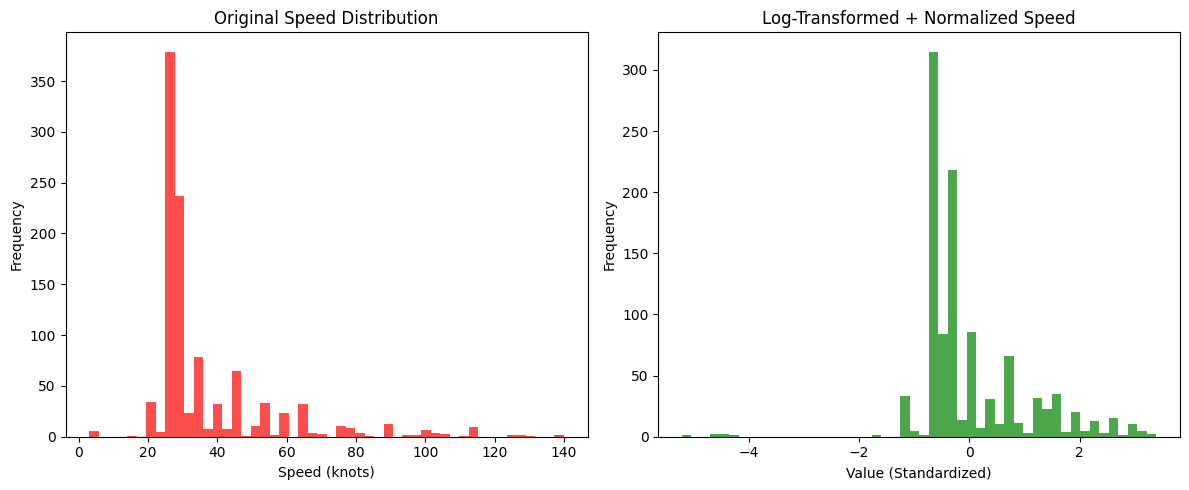

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler

# # Assuming you already have y_speed (raw, not scaled yet)
# # If yours is already scaled, inverse_transform it first.
# y_speed_norm = speed_scaler.inverse_transform(y_speed_norm.reshape(-1, 1))

# # 1. Original Distribution
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.hist(y_speed, bins=50, color='red', alpha=0.7)
# plt.title("Original Speed Distribution")
# plt.xlabel("Speed (knots)")
# plt.ylabel("Frequency")

# # 2. Log Transform + Scaling
# y_speed_log = np.log1p(y_speed)  # log(1 + x) to handle 0 safely
# speed_scaler_log = StandardScaler()
# y_speed_log_norm = speed_scaler_log.fit_transform(y_speed_log.reshape(-1,1))

# # 3. Plot Transformed Distribution
# plt.subplot(1,2,2)
# plt.hist(y_speed_log_norm, bins=50, color='green', alpha=0.7)
# plt.title("Log-Transformed + Normalized Speed")
# plt.xlabel("Value (Standardized)")
# plt.ylabel("Frequency")

# plt.tight_layout()
# plt.show()

In [ ]:

# ==========================================================
# 2. Prepare Sequences
# ==========================================================
num_days = X_features.shape[0]
seq_start_idxs = np.arange(0, num_days - TIME_STEPS + 1)

train_idx, val_idx = train_test_split(
    seq_start_idxs, test_size=0.2, random_state=42, shuffle=True
)

train_gen = SeqDataGenerator(
    X_features, y_lat_norm, y_lon_norm, y_speed_norm,
    train_idx, TIME_STEPS, band_means, band_stds,
    batch_size=12, shuffle=True
)

val_gen = SeqDataGenerator(
    X_features, y_lat_norm, y_lon_norm, y_speed_norm,
    val_idx, TIME_STEPS, band_means, band_stds,
    batch_size=12, shuffle=False
)

# ==========================================================
# 3. Compile Stage-2 Model
# ==========================================================
optimizer = AdamW(
    learning_rate=1e-5,      # Reduced from 1e-4
    clipnorm=0.5,
    weight_decay = 0.01# Prevents exploding gradients
)

# Huber loss - more robust than MSE
def huber_loss(delta=0.5):
    def loss_fn(y_true, y_pred):
        error = y_true - y_pred
        condition = tf.abs(error) <= delta
        squared_loss = 0.5 * tf.square(error)
        linear_loss = delta * tf.abs(error) - 0.5 * tf.square(delta)
        return tf.where(condition, squared_loss, linear_loss)
    return loss_fn

stage2_model.compile(
    optimizer=optimizer,
    loss=[huber_loss(0.3), huber_loss(0.3), huber_loss(1.0)],
    loss_weights=[1.5, 1.5, 2.0],  # Weight coordinates more
    metrics=[['mae'], ['mae'], ['mae']]
)


# ==========================================================
# 4. Callbacks
# ==========================================================
unfreeze_callback = UnfreezeCallback(
    stage2_model, 
    unfreeze_at=20, 
    optimizer=optimizer,
    losses = [huber_loss(0.3),huber_loss(0.3),huber_loss(1.0)],
    loss_weights=[1.5, 1.5, 2.0],
    metrics = [['mae'],['mae'],['mae']]
)

lr_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 5,
    min_lr = 1e-6,
    verbose = 1
)

class CosineAnnealingScheduler(tf.keras.callbacks.Callback):
    def __init__(self, T_max, eta_max, eta_min=1e-6, verbose=1):
        super().__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose


# 🔓 Gradual unfreeze callback (safe version)
class GradualUnfreeze(tf.keras.callbacks.Callback):
    def __init__(self, unfreeze_epoch=20):
        super().__init__()
        self.unfreeze_epoch = unfreeze_epoch

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.unfreeze_epoch:
            print(f"\n🔓 Unfreezing ConvLSTM backbone at epoch {epoch}...\n")
            for layer in self.model.layers:
                if "conv_lstm2d" in layer.name.lower():
                    layer.trainable = True

            
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1}: Learning rate is {lr:.6e}")

cosine_scheduler = CosineAnnealingScheduler(
    T_max=20,      # cycle length in epochs
    eta_max=1e-4,  # peak LR
    eta_min=1e-6   # minimum LR
)


USE_COSINE = True

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('emergency_fixed_model.keras', monitor='val_loss', save_best_only=True),
    GradualUnfreeze(unfreeze_epoch=20),
    cosine_scheduler,
    LRLogger()
]

# ==========================================================
# 5. Train Model
# ==========================================================

history = stage2_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=120,     # try 100 first, can increase to 200
    callbacks=callbacks,
    verbose=1,
    batch_size = 12
)

# ==========================================================
# 6. Denormalize Predictions for Evaluation
# ==========================================================
preds = stage2_model.predict(val_gen)

# preds = [lat_norm, lon_norm, speed_norm]
pred_lat   = lat_scaler.inverse_transform(preds[0].reshape(-1,1))
pred_lon   = lon_scaler.inverse_transform(preds[1].reshape(-1,1)) 
pred_speed = speed_scaler.inverse_transform(preds[2].reshape(-1,1))

print("Example denormalized predictions:")
print("Lat:", pred_lat[:5].ravel())
print("Lon:", pred_lon[:5].ravel())
print("Speed:", pred_speed[:5].ravel())


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/120
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.0222 - out_lat_loss: 0.0873 - out_lat_mae: 0.4249 - out_lon_loss: 0.0767 - out_lon_mae: 0.3792 - out_speed_loss: 0.3881 - out_speed_mae: 0.7248Epoch 1: Learning rate is 1.000000e-05
70/70 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - loss: 1.0217 - out_lat_loss: 0.0874 - out_lat_mae: 0.4251 - out_lon_loss: 0.0767 - out_lon_mae: 0.3792 - out_speed_loss: 0.3877 - out_speed_mae: 0.7246 - val_loss: 0.9764 - val_out_lat_loss: 0.0857 - val_out_lat_mae: 0.4183 - val_out_lon_loss: 0.0622 - val_out_lon_mae: 0.3296 - val_out_speed_loss: 0.3772 - val_out_speed_mae: 0.7108
Epoch 2/120
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.0444 - out_lat_loss: 0.0906 - out_lat_mae: 0.4354 - out_lon_loss: 0.0760 - out_lon_mae: 0.3797 - out_speed_loss: 0.3973 - out_speed_mae: 0.7423Epoch 2: Learning rate is 1.000000e-05
70/70 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 1.0437 - out_lat_loss: 0.0906 - out_lat_mae: 0.4355 - out_lon_loss: 0.0760 - out_lon_mae: 0.37

In [25]:
import pandas as pd
import numpy as np

# STEP 1: Generate FRESH predictions from your improved model
print("Generating fresh predictions from improved model...")
fresh_predictions = stage2_model.predict(val_gen)

# Extract fresh predictions
fresh_pred_lat_norm = fresh_predictions[0].reshape(-1, 1)
fresh_pred_lon_norm = fresh_predictions[1].reshape(-1, 1)
fresh_pred_speed_norm = fresh_predictions[2].reshape(-1, 1)

# STEP 2: Apply correct denormalization
fresh_pred_lat   = lat_scaler.inverse_transform(fresh_pred_lat_norm).flatten()
fresh_pred_lon   = lon_scaler.inverse_transform(fresh_pred_lon_norm).flatten()
fresh_pred_speed = speed_scaler.inverse_transform(fresh_pred_speed_norm).flatten()

# STEP 3: Align with validation indices
# Make sure lengths match between preds and true values
val_indices = val_idx[:len(fresh_pred_lat)]

true_lat = aligned_df.iloc[val_indices]['lat'].values
true_lon = aligned_df.iloc[val_indices]['lon'].values
true_speed = aligned_df.iloc[val_indices]['speed'].values

# STEP 4: Build comparison DataFrame
N = min(10, len(fresh_pred_lat))  # avoid index errors if < 10
df_compare_fresh = pd.DataFrame({
    "True_Lat": true_lat[:N],
    "Pred_Lat": fresh_pred_lat[:N],
    "True_Lon": true_lon[:N], 
    "Pred_Lon": fresh_pred_lon[:N],
    "True_Speed": true_speed[:N],
    "Pred_Speed": fresh_pred_speed[:N],
    
    "Lat_Error": np.abs(true_lat[:N] - fresh_pred_lat[:N]),
    "Lon_Error": np.abs(true_lon[:N] - fresh_pred_lon[:N]),
    "Speed_Error": np.abs(true_speed[:N] - fresh_pred_speed[:N])
})

print("FRESH Prediction Comparisons:")
print(df_compare_fresh.round(3))

print(f"\nUPDATED Performance Summary (with FRESH predictions):")
print(f"Latitude MAE:  {df_compare_fresh['Lat_Error'].mean():.3f}")
print(f"Longitude MAE: {df_compare_fresh['Lon_Error'].mean():.3f}")
print(f"Speed MAE:     {df_compare_fresh['Speed_Error'].mean():.3f}")


Generating fresh predictions from improved model...
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step
FRESH Prediction Comparisons:
   True_Lat   Pred_Lat  True_Lon   Pred_Lon  True_Speed  Pred_Speed  \
0    21.343  15.517000    88.714  87.849998      30.000   31.552000   
1    23.629  15.029000    92.286  87.927002      60.000   33.188999   
2    18.025  15.380000    84.837  87.154999      25.000   32.261002   
3    10.062  15.028000    83.088  88.016998      50.000   33.057999   
4    19.862  17.514999    87.112  87.249001      31.774   34.407001   
5    17.750  14.780000    86.438  87.528000      30.000   33.030998   
6    23.662  15.801000    86.662  87.879997      25.833   31.944000   
7    18.375  15.658000    94.325  87.914001      26.667   31.815001   
8    13.900  13.624000    88.588  88.425003      45.000   34.237000   
9    23.000  14.667000    86.500  88.011002      25.000   33.021000   

   Lat_Error  Lon_Error  Speed_Error  
0      5.826      0.864        1.552  
1      8.599     